# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

**Answer:**

This is a classification problem. Classification is simply the process of taking some kind of input and mapping it to some discrete label. In this problem, our goal is to predict whether or not a student passes the final exam (binary classification: yes, or no).

Regression is more about continuous value function. So, something like giving a bunch of points and finding some real value for the new given point. 

The difference between classification and regression is the difference between mapping from some input to some small number of discrete values. And regression is mapping from some input space to some real number.


## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [2]:
# Import libraries
import numpy as np
import pandas as pd

In [3]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [4]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = student_data.shape[0]
n_features = student_data.shape[1] - 1  # The column "pass", is the target label 

print(student_data["passed"].unique())

n_passed = student_data["passed"].value_counts()['yes']
n_failed = student_data["passed"].value_counts()['no']

grad_rate = float( n_passed ) / n_students  * 100

print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

['no' 'yes']
Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


When dealing with the new data set it is good practice to assess its specific characteristics and implement the cross validation technique tailored on those very characteristics, in our case there are two main elements:

* Our dataset is small.
* Our dataset is slightly unbalanced. (There are more passing students than on passing students)

We could take advantage of K-fold cross validation to exploit small data sets. Even though in this case it might not be necessary, should we have to deal with heavily unbalance datasets, we could address the unbalanced nature of our data set using Stratified K-Fold and Stratified Shuffle Split Cross validation, as stratification is preserving the preserving the percentage of samples for each class.

http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedKFold.html

## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [5]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [6]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [7]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=num_train, random_state=0)

print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.



**Answer:**

There are a number of dimensions that can be looked at to give us some sense of what will be a reasonable algorithm to choose, here are few of them:

1. Number of training examples.
2. Dimensionality of the feature space.
3. Do I expect the problem to be linearly separable?
4. Are features independent?
5. What are the system's requirement in terms of speed/performance/memory usage...?

Here are my model choices:

**RandomForest**

A random forest is an ensemble of decision trees which will output a prediction value, in this case student intervention. Each decision tree is constructed by using a random subset of the training data. After you have trained your forest, you can then pass each test row through it, in order to output a prediction.  Its high accuracy, and running efficiently on large data sets are the reasons for me choosing Random forest for this problem.

The main limitation of the Random Forests algorithm is that a large number of trees may make the algorithm slow for real-time prediction.

**SVM**

The Support Vector Machine (SVM) classifier is a powerful classifier that works well on a wide range of classification problems, even problems in high dimensions and that are not linearly separable. Due to its high accuracy, ability to deal with high-dimensional data, and flexibility in modeling linear and non-linear classifers, I chose this algorithem. 

The main disadvantage of the SVM algorithm is that it has several key parameters that need to be set correctly to achieve the best classification results for any given problem. Parameters that may result in an excellent classification accuracy for problem A, may result in a poor classification accuracy for problem B. The user may, therefore, have to experiment with a number of different parameter settings in order to achieve a satisfactory result. 

**K-Nearest Neighbor (KNN)**

The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. The number of samples can be a user-defined constant (k-nearest neighbor learning), or vary based on the local density of points (radius-based neighbor learning). Despite its simplicity, nearest neighbors has been successful in a large number of classification problems, that was the reason I chose this algorithm.

The main disadvantage of the KNN algorithm is that it is a lazy learner, i.e. it does not learn anything from the training data and simply uses the training data itself for classification. Another disadvantage of tthe algorithm is that it must compute the distance and sort all the training data at each prediction, which can be slow if there are a large number of training examples. Another disadvantage is that the algorithm not generalizing well and also not being robust to noisy data. Further, changing K can change the resulting predicted class label.


In [8]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)

# TODO: Choose a model, import it and instantiate an object
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=1, max_depth=5, n_estimators=150, min_samples_split=4, min_samples_leaf=2)

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here

#print clf  # you can inspect the learned model by printing it
print clf

Training RandomForestClassifier...
Done!
Training time (secs): 0.335
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)


In [9]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')

train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)

Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.018
F1 score for training set: 0.874734607219


In [10]:
# Predict on test data
print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.016
F1 score for test set: 0.797297297297


In [11]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant


train_predict(clf, X_train[0:100], y_train[0:100], X_test, y_test)
train_predict(clf, X_train[0:200], y_train[0:200], X_test, y_test)
train_predict(clf, X_train, y_train, X_test, y_test)

------------------------------------------
Training set size: 100
Training RandomForestClassifier...
Done!
Training time (secs): 0.322
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.010
F1 score for training set: 0.948148148148
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.010
F1 score for test set: 0.794520547945
------------------------------------------
Training set size: 200
Training RandomForestClassifier...
Done!
Training time (secs): 0.300
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.012
F1 score for training set: 0.898648648649
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.009
F1 score for test set: 0.783783783784
------------------------------------------
Training set size: 300
Training RandomForestClassifier...
Done!
Training time (secs): 0.292
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.013
F1 sc

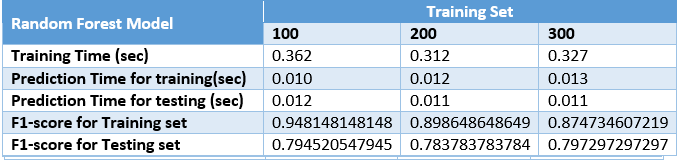

In [12]:
from IPython.display import Image
Image(filename='Random Forest.PNG')

In [13]:
# TODO: Train and predict using two other models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

two_other_classifiers = [   
     KNeighborsClassifier(n_neighbors=5),
     SVC(kernel="linear")]
    
for clf in two_other_classifiers: 
    train_predict(clf, X_train[0:100], y_train[0:100], X_test, y_test)
    train_predict(clf, X_train[0:200], y_train[0:200], X_test, y_test)
    train_predict(clf, X_train, y_train, X_test, y_test)   

------------------------------------------
Training set size: 100
Training KNeighborsClassifier...
Done!
Training time (secs): 0.000
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.002
F1 score for training set: 0.797202797203
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.706766917293
------------------------------------------
Training set size: 200
Training KNeighborsClassifier...
Done!
Training time (secs): 0.000
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.004
F1 score for training set: 0.857142857143
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.712121212121
------------------------------------------
Training set size: 300
Training KNeighborsClassifier...
Done!
Training time (secs): 0.001
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.007
F1 score for training

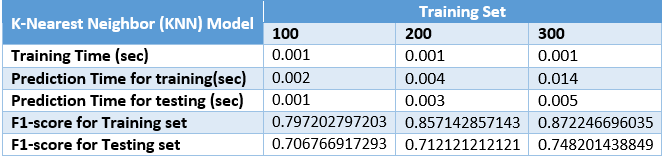

In [14]:
Image(filename='KNN.PNG')

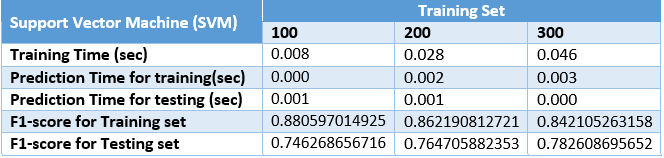

In [15]:
Image(filename='SVM.PNG')

## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

**Answer:**

Based on the expeermintes performed above for model selection, the best model I choose is SVM's method used for classification (SVC). Here are the reasons:

1. The training time for 300 data for Random forest is 0.362 compared to SVC which is 0.008. SVC performs almost 45 times faster than RandomForest which has slightly higer F1 score.
2. KNN is about 46 times faster than training of 300 points compared to SVC, however, the KNN F1-score is much lower than SVC.
3. F1 score for SVC model is the higest for 300 training set amongst other models (RandomForest is slightly higher +0.0085). 

The Student Intervention System that we have designed is a classification problem. In layman's terms, the system will predict whether or not a student will pass or fail the exams based on his/her attributes such as study time, health status, number of school absences, internet access at home, and many more. This will allow the supervisors to intervine ontime before the student drops out of school. 

In order our system to predict the future, we use the current information at hand of all the students who already passed or failed the final exam. We train our system by feeding all this data, so that it ’learns’ how to best separate passing and failing student.

The model we found that has the most accuracy seperating the data and has the best performance for this specific case is called ’Support vector machine’ or SVM in short. This is a powerful model which searches for a line that best separates passing and failing students using their provided information. To make things easier, let’s have a look at the following figure:

<img src="SVM-0.png" alt="Classification" height="450" width="350">

Imagine that blue dots are student passing final exam, red dots are failing students, and let’s assume that the x-axis (labeled x1) represents the study hours, and that y-axis (labeled x2) represents health status. SVM looks for a line that separates the two types, let’s say something like:

<img src="SVM-1.png" alt="Classification" height="450" width="350">

After the model learns how to devide passing or failing students, a new student info is provided to the SVM model, and the model will predict the expected final results. In the context of the example above, SVM will try to map each new student to red or blue areas.

If the data are not lineraly seperable, SVMs can efficiently perform a non-linear seperation using what is called the kernel trick. We achieve this not by drawing curves, but by "lifting" the red dots outside of the picture plane and keep the blue dots inside. In this scenario we devide red and blue dots using hyperplanes and calculate the best distance between the dots that will have the largest seperation. 

In [16]:
# TODO: Fine-tune your model and report the best F1 score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics

#tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                     'C': [0.25, 1, 10, 100]},
#                    {'kernel': ['linear'], 'C': [0.25, 1, 10]}]

tuned_parameters = [
  {'C': [0.025, 0.25, 0.5, 1, 10, 100], 'kernel': ['linear']},
  {'C': [0.025, 0.25, 0.5, 1, 10], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]


custom_f1_scorer = metrics.make_scorer(f1_score, pos_label='yes')

clf = GridSearchCV(SVC(), tuned_parameters, cv=4, scoring=custom_f1_scorer)

clf.fit(X_train, y_train)
print "Best parameters:"
print
print clf.best_params_
print

train_predict(clf, X_train, y_train, X_test, y_test)



Best parameters:

{'kernel': 'linear', 'C': 0.025}

------------------------------------------
Training set size: 300
Training GridSearchCV...
Done!
Training time (secs): 12.310
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.003
F1 score for training set: 0.835758835759
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.794520547945


The final F1 score is **0.7945**


We could actually go well beyond grid search and implement ‘pipelines’ where the whole machine learning process becomes 'grid-searchable' and we can parameterize and search the whole process though cross validation.

http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

Here is a great, informative, top notch tutorial from Zac Sewart!

http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html